# Week 2 Assignment — Cancer Outcome Prediction
DataVerse Africa Internship Cohort 3.0 — Data Science Track

**What you’ll do**: Demonstrate Classification models and metrics

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os, pathlib

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC

## Load Data

In [3]:
!wget -O seer_breast.csv "https://zenodo.org/record/5120960/files/SEER%20Breast%20Cancer%20Dataset%20.csv?download=1"

--2025-10-19 07:49:58--  https://zenodo.org/record/5120960/files/SEER%20Breast%20Cancer%20Dataset%20.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5120960/files/SEER%20Breast%20Cancer%20Dataset%20.csv [following]
--2025-10-19 07:49:58--  https://zenodo.org/records/5120960/files/SEER%20Breast%20Cancer%20Dataset%20.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 520033 (508K) [text/plain]
Saving to: ‘seer_breast.csv’

seer_breast.csv     100%[===================>] 507.84K   889KB/s    in 0.6s    

2025-10-19 07:49:59 (889 KB/s) - ‘seer_breast.csv’ saved [520033/520033]



In [7]:
fn = "seer_breast.csv"
df = pd.read_csv(fn)
display(df.head())

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


## EDA

In [8]:
df.isnull().sum()

,0
Age,0
Race,0
Marital Status,0
Unnamed: 3,4024
T Stage,0
N Stage,0
6th Stage,0
Grade,0
A Stage,0
Tumor Size,0


In [10]:
#check values of unnamed column
df['Unnamed: 3'].unique()

array([nan])

In [12]:
# Drop "Unnamed" column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.columns)

Index(['Age', 'Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')


In [14]:
df.duplicated().sum()
df[df.duplicated(keep=False)]

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
1009,63,White,Married (including common law),T1,N1,IIA,Moderately differentiated; Grade II,Regional,17,Positive,Positive,9,1,56,Alive
1010,63,White,Married (including common law),T1,N1,IIA,Moderately differentiated; Grade II,Regional,17,Positive,Positive,9,1,56,Alive


Duplicate record found, in the absence of patient identifiers, it cannot be confirmed whether this represents a data entry error or two patients with identical characteristics.

Since it does not represent new information, one copy removed to prevent biasing the model.

In [19]:
df=df.drop_duplicates()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4023 entries, 0 to 4023
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4023 non-null   int64 
 1   Race                    4023 non-null   object
 2   Marital Status          4023 non-null   object
 3   T Stage                 4023 non-null   object
 4   N Stage                 4023 non-null   object
 5   6th Stage               4023 non-null   object
 6   Grade                   4023 non-null   object
 7   A Stage                 4023 non-null   object
 8   Tumor Size              4023 non-null   int64 
 9   Estrogen Status         4023 non-null   object
 10  Progesterone Status     4023 non-null   object
 11  Regional Node Examined  4023 non-null   int64 
 12  Reginol Node Positive   4023 non-null   int64 
 13  Survival Months         4023 non-null   int64 
 14  Status                  4023 non-null   object
dtypes: int64(

In [21]:
display(df.describe(include='all'))

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
count,4023.000000,4023,4023,4023,4023,4023,4023,4023,4023.000000,4023,4023,4023.000000,4023.000000,4023.000000,4023
unique,NaN,3,5,4,3,5,4,2,NaN,2,2,NaN,NaN,NaN,2
top,NaN,White,Married (including common law),T2,N1,IIA,Moderately differentiated; Grade II,Regional,NaN,Positive,Positive,NaN,NaN,NaN,Alive
freq,NaN,3412,2642,1786,2731,1304,2350,3931,NaN,3754,3325,NaN,NaN,NaN,3407
mean,53.969923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.477007,NaN,NaN,14.358439,4.158837,71.301765,NaN
std,8.963118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.121253,NaN,NaN,8.100241,5.109724,22.923009,NaN
min,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN
25%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,9.000000,1.000000,56.000000,NaN
50%,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,NaN,NaN,14.000000,2.000000,73.000000,NaN
75%,61.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,NaN,19.000000,5.000000,90.000000,NaN


The machine learning model is supposed to predict survival based on features known at the time of diagnosis: age, tumor size, nodes, stage, etc.

If Survival Months is included, we will be giving the model the answer it is trying to predict, constituting data leakage. Therefore, that feature will be dropped.

In [22]:
# Dropping the 'Survival Months' column
df = df.drop(columns=["Survival Months"])

In [26]:
# renaming columns
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

In [27]:
df.columns

Index(['age', 'race', 'marital_status', 't_stage', 'n_stage', '6th_stage',
       'grade', 'a_stage', 'tumor_size', 'estrogen_status',
       'progesterone_status', 'regional_node_examined',
       'reginol_node_positive', 'status'],
      dtype='object')

In [28]:
# renaming column with typo
df.rename(columns={'reginol_node_positive': 'regional_node_positive'}, inplace=True)
df.columns

Index(['age', 'race', 'marital_status', 't_stage', 'n_stage', '6th_stage',
       'grade', 'a_stage', 'tumor_size', 'estrogen_status',
       'progesterone_status', 'regional_node_examined',
       'regional_node_positive', 'status'],
      dtype='object')

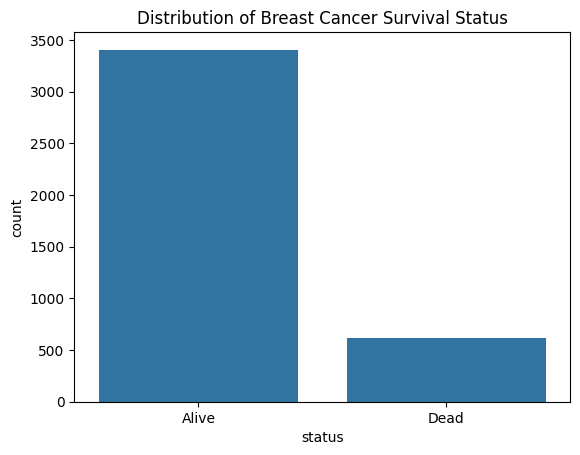

In [31]:
# Countplot of target variable
sns.countplot(x='status', data=df)
plt.title("Distribution of Breast Cancer Survival Status")
plt.show()

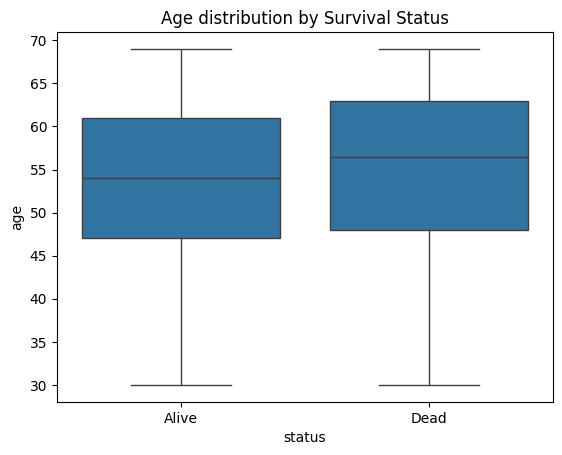

In [34]:
sns.boxplot(x='status', y='age', data=df)
plt.title("Age distribution by Survival Status")
plt.show()

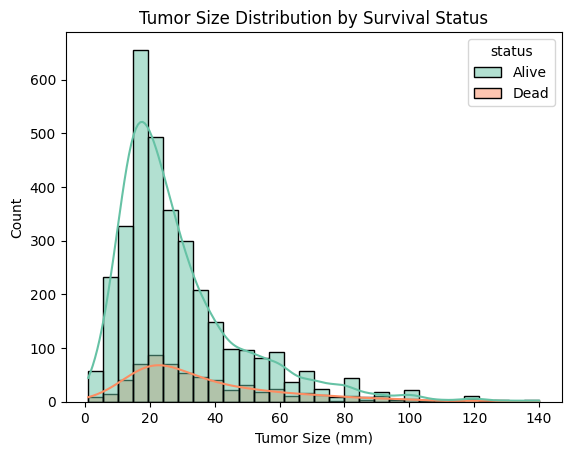

In [36]:
sns.histplot(data=df, x='tumor_size', hue='status', kde=True, bins=30, palette='Set2')
plt.title("Tumor Size Distribution by Survival Status")
plt.xlabel("Tumor Size (mm)")
plt.ylabel("Count")
plt.show()

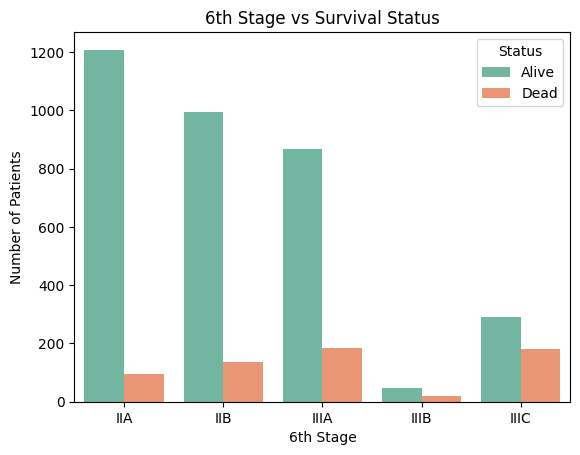

In [42]:
stage_order = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']  # specify the clinically correct order

sns.countplot(x='6th_stage', hue='status', data=df, palette='Set2', order=stage_order)
plt.title("6th Stage vs Survival Status")
plt.xlabel("6th Stage")
plt.ylabel("Number of Patients")
plt.legend(title='Status', labels=['Alive', 'Dead'])
plt.show()

In [43]:
# percentage of missing values per column
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent)

age                       0.0
race                      0.0
marital_status            0.0
t_stage                   0.0
n_stage                   0.0
6th_stage                 0.0
grade                     0.0
a_stage                   0.0
tumor_size                0.0
estrogen_status           0.0
progesterone_status       0.0
regional_node_examined    0.0
regional_node_positive    0.0
status                    0.0
dtype: float64


Mapping to preserve the ordinal relationship between catgories

In [44]:
ordinal_cols = ['t_stage', 'n_stage', '6th_stage', 'grade', 'a_stage']

# check unique values for ordinal columns
for col in ordinal_cols:
    print(f"{col}: {df[col].unique()}")

t_stage: ['T2' 'T1' 'T3' 'T4']
n_stage: ['N3' 'N2' 'N1']
6th_stage: ['IIIC' 'IIIA' 'IIB' 'IIA' 'IIIB']
grade: ['Moderately differentiated; Grade II' 'Poorly differentiated; Grade III'
 'Well differentiated; Grade I' 'Undifferentiated; anaplastic; Grade IV']
a_stage: ['Regional' 'Distant']


In [45]:
# Map T Stage (T1 < T2 < T3 < T4)
t_stage_mapping = {'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4}
df['t_stage'] = df['t_stage'].map(t_stage_mapping)

# Map N Stage (N1 < N2 < N3)
n_stage_mapping = {'N1': 1, 'N2': 2, 'N3': 3}
df['n_stage'] = df['n_stage'].map(n_stage_mapping)

# Map 6th Stage (Assuming order: IIA < IIB < IIIA < IIIB < IIIC)
sixth_stage_mapping = {'IIA': 1, 'IIB': 2, 'IIIA': 3, 'IIIB': 4, 'IIIC': 5}
df['6th_stage'] = df['6th_stage'].map(sixth_stage_mapping)

# Map Grade (Well < Moderate < Poor < Undifferentiated)
grade_mapping = {
    'Well differentiated; Grade I': 1,
    'Moderately differentiated; Grade II': 2,
    'Poorly differentiated; Grade III': 3,
    'Undifferentiated; anaplastic; Grade IV': 4
}
df['grade'] = df['grade'].map(grade_mapping)

# Map A Stage (Regional < Distant)
a_stage_mapping = {'Regional': 1, 'Distant': 2}
df['a_stage'] = df['a_stage'].map(a_stage_mapping)

# check result
print(df[['t_stage','n_stage','6th_stage','grade','a_stage']].head())

   t_stage  n_stage  6th_stage  grade  a_stage
0        2        3          5      2        1
1        2        2          3      2        1
2        2        1          2      3        1
3        1        1          1      2        1
4        2        2          3      2        1


## Train/test split and preprocessing (leak‑safe)

In [46]:
#target variable
target = 'status'

#features
features = [c for c in df.columns if c != target]
print(features)

['age', 'race', 'marital_status', 't_stage', 'n_stage', '6th_stage', 'grade', 'a_stage', 'tumor_size', 'estrogen_status', 'progesterone_status', 'regional_node_examined', 'regional_node_positive']


In [47]:
X = df[features]
y = df[target]

In [48]:
X.head()

,age,race,marital_status,t_stage,n_stage,6th_stage,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),2,3,5,2,1,40,Positive,Positive,19,11
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),2,2,3,2,1,45,Positive,Positive,25,9
2,67,White,Married (including common law),2,1,2,3,1,25,Positive,Positive,4,1
3,46,White,Divorced,1,1,1,2,1,19,Positive,Positive,26,1
4,63,White,Married (including common law),2,2,3,2,1,35,Positive,Positive,21,5


In [49]:
y.head()

,status
0,Alive
1,Alive
2,Dead
3,Dead
4,Dead


In [50]:
#splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [53]:
# isolating ordinal features
ordinal_features = ['t_stage','n_stage','6th_stage','grade','a_stage']
print(f"ordinal: {ordinal_features}")
#seperating numerical from categorical
numeric_features = [col for col in numeric_features if col not in ordinal_features]
print(f"numerical: {numeric_features}")
categorical_features = [col for col in categorical_features if col not in ordinal_features]
print (f"categorical: {categorical_features}")

ordinal: ['t_stage', 'n_stage', '6th_stage', 'grade', 'a_stage']
numerical: ['age', 'tumor_size', 'regional_node_examined', 'regional_node_positive']
categorical: ['race', 'marital_status', 'estrogen_status', 'progesterone_status']


In [62]:
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())  # preserves order
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features),
    ('ord', ordinal_pipe, ordinal_features)
])

## Models

In [63]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix, matthews_corrcoef,
    balanced_accuracy_score
)

# Evaluation function for classification
def evaluate_classification(model, X_train, y_train, X_test, y_test, name='model'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]  # probability for log loss & ROC AUC

    # Specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    specificity = tn / (tn + fp)

    metrics_dict = {
        'model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds),
        'Specificity': specificity,
        'ROC_AUC': roc_auc_score(y_test, probs),
        'Log_Loss': log_loss(y_test, probs),
        'MCC': matthews_corrcoef(y_test, preds),
        'Balanced_Accuracy': balanced_accuracy_score(y_test, preds)
    }

    print(f"=== {name} ===")
    for k, v in metrics_dict.items():
        if k != 'model':
            print(f"{k}: {v:.3f}")
    print()

    return metrics_dict

# Define your pipelines
logreg_pipe = Pipeline([
    ('prep', preprocess),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipe = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42))
])

svm_pipe = Pipeline([
    ('prep', preprocess),
    ('svm', SVC(probability=True, kernel='rbf', random_state=42))
])

# Evaluate models
scores = []
scores.append(evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test, 'LogisticRegression'))
scores.append(evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test, 'RandomForest'))
scores.append(evaluate_classification(svm_pipe, X_train, y_train, X_test, y_test, 'SVM'))

# Create summary table
import pandas as pd
pd.DataFrame(scores)


=== LogisticRegression ===
Accuracy: 0.855
Precision: 0.615
Recall: 0.130
F1: 0.215
Specificity: 0.985
ROC_AUC: 0.741
Log_Loss: 0.373
MCC: 0.235
Balanced_Accuracy: 0.558

=== RandomForest ===
Accuracy: 0.847
Precision: 0.500
Recall: 0.106
F1: 0.174
Specificity: 0.981
ROC_AUC: 0.704
Log_Loss: 0.447
MCC: 0.176
Balanced_Accuracy: 0.543

=== SVM ===
Accuracy: 0.855
Precision: 0.714
Recall: 0.081
F1: 0.146
Specificity: 0.994
ROC_AUC: 0.641
Log_Loss: 0.401
MCC: 0.208
Balanced_Accuracy: 0.538



,model,Accuracy,Precision,Recall,F1,Specificity,ROC_AUC,Log_Loss,MCC,Balanced_Accuracy
0,LogisticRegression,0.854658,0.615385,0.130081,0.214765,0.985337,0.741006,0.372924,0.234890,0.557709
1,RandomForest,0.847205,0.500000,0.105691,0.174497,0.980938,0.704146,0.447386,0.176301,0.543315
2,SVM,0.854658,0.714286,0.081301,0.145985,0.994135,0.641215,0.401324,0.207620,0.537718


**Observations**
- Accuracy high for all models: misleading due to class imbalance (many more alive than dead)
- Recall very low for all models: This shows that the models are struggling to identify high-risk patients, which is clinically critical
- Specificity very high for all models: all models are very good at identifying alive patients.
- F1 / MCC: Low across the board, reflecting poor performance on minority class.
- Log loss lowest for Logistic Regression: The LogReg model’s predicted probabilities more closely reflect the true chance of each outcome than the other models.
- Balanced Accuracy low for all: minority class is poorly predicted in all models.
- ROC AUC: Logistic Regression has the highest ROC AUC, indicating it best separates alive vs dead patients overall.


Logistic Regression would generally be considered the best choice for implementation here. Its higher ROC AUC suggests it better separates patients into the correct outcome categories. Misclassifying a patient as low risk when they are high risk is more consequential than a few extra correct predictions in the majority class.